In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import random
import itertools
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.collections
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from tqdm import *

import keras
from keras.applications import *
import lightgbm as lgbm
from scipy import stats
from keras.models import Sequential, Model
from keras.layers import * #Dense, Dropout, Activation, Flatten, Input,Concatenate, concatenate
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import cv2 as cv
from os import listdir
from os.path import isfile, join
from scipy import misc
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop

Using TensorFlow backend.


In [2]:
plt.ion()
plt.show()

In [87]:
basedir = 'data/dogs/'
files = [f for f in listdir(basedir) if isfile(join(basedir, f))]
len(files)
img_size = 160

In [99]:
def normalize(arr):
    arr=arr.astype('float32')
    if arr.max() > 1.0:
        arr/=255.0
    return arr

def resizeImg(Xg):
#     plt.imshow(Xg)
#     plt.show()
#     cv.normalize(Xg,  Xg, 0, 1, cv.NORM_MINMAX)
#     Xg/=255.0
    Xg = normalize(Xg)
    return cv.resize(Xg,(img_size,img_size), cv.INTER_AREA)
#     if Xg.shape[0] >= img_size:
#         return cv.resize(Xg,(img_size,img_size), cv.INTER_AREA)
#     else:
#         return cv.resize(Xg,(img_size,img_size), cv.INTER_CUBIC)

    
def readAndResize(filename):
    dog = misc.imread(basedir + filename)
    return resizeImg(dog)

(160, 160, 3)


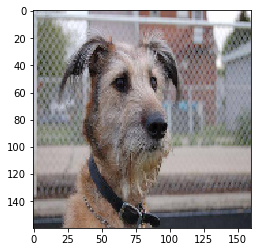

In [100]:
dog = readAndResize(files[random.randint(0, len(files))])
print(dog.shape)
plt.imshow(dog)
# readAndResize(files[0])

(375, 500, 3)


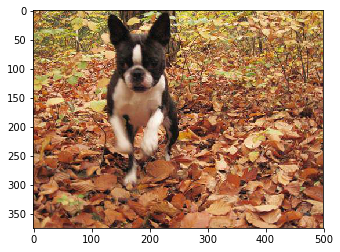

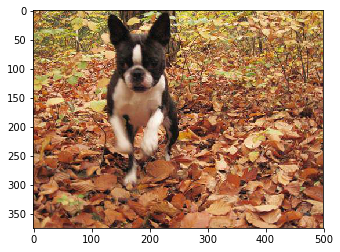

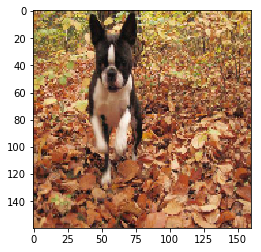

In [90]:
dog = misc.imread(basedir + files[0])
print(dog.shape)
plt.imshow(dog)
plt.show()
plt.imshow(resizeImg(dog))
plt.show()

In [91]:
def getInputImages(ids):
    data = [readAndResize(i) for i in  ids]
    data = np.stack(data)
    return data

In [92]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.acc = [] #
        self.fig = plt.figure()
        self.logs = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):     
        self.i += 1

        if self.i% 1 != 0:
            return
        
        self.losses.append(logs.get('loss'))

        self.acc.append(logs.get('acc'))
        self.logs.append(logs)
        self.x.append(self.i)
        
        clear_output(wait=True)
        plt.figure(figsize=(16,8))
        plt.subplot(1,3,1)
        self.plotLosses(None)
        

        

    def plotLosses(self, ax):
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.acc, label="accuracy")

        plt.legend()
        
        
myPlot = PlotLosses()
myPlot.initVars()

## GAN

In [93]:
img_size = 160
img_rows = img_size
img_cols = img_size
channels = 3
img_shape = (img_rows, img_cols, channels)
epochs = 100
batch_size = 20
save_interval= 10
half_batch = int(batch_size / 2)



In [102]:
def build_generator():

    noise_shape = (100,)
    noise = Input(shape=noise_shape)
    depth = 64 *4
    dim = 10

    x = Dense(dim * dim *depth, activation='tanh', input_shape=noise_shape)(noise)
#     x = BatchNormalization(momentum=0.9)(x)
#     x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((dim, dim, depth))(x)
    x = Dropout(0.4)(x)
    
    x = UpSampling2D((4,4))(x)
    x = Convolution2D(int(depth/2), 5, padding='same', activation='tanh')(x)
#     x = BatchNormalization(momentum=0.9)(x)
    
    x = UpSampling2D((2,2))(x)
    x = Convolution2D(int(depth/4), 5, padding='same', activation='tanh')(x)
#     x = BatchNormalization(momentum=0.9)(x)
    
    x = UpSampling2D((2,2))(x)
    x = Convolution2D(int(depth/8), 5, padding='same', activation='tanh')(x)
#     x = BatchNormalization(momentum=0.9)(x)
    
    
    x = Convolution2D(3, 5, padding='same', activation='tanh')(x)
    model = Model(noise, x)


    model.compile(optimizer=RMSprop(lr=0.0002, decay=6e-8), loss='binary_crossentropy', metrics=['accuracy'])
#     model.compile(optimizer=Adam(0.0001, 0.3), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return Model(noise, x)

generator = build_generator()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 25600)             2585600   
_________________________________________________________________
reshape_18 (Reshape)         (None, 10, 10, 256)       0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 10, 10, 256)       0         
_________________________________________________________________
up_sampling2d_53 (UpSampling (None, 40, 40, 256)       0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 40, 40, 128)       819328    
_________________________________________________________________
up_sampling2d_54 (UpSampling (None, 80, 80, 128)       0         
__________

In [101]:

def build_discriminator():
    img_shape = (img_rows, img_cols, channels)
    input_img = Input(shape=img_shape)
    depth = 64
    x = Convolution2D(depth, (5, 5), activation='relu', padding='same', input_shape=img_shape)(input_img)
    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
#     x = LeakyReLU(0.2) (x)
#     x = Dropout(0.6)(x)
    
    x = Convolution2D(depth *2 , (4, 4), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
    x = LeakyReLU(0.2) (x)
#     x = Dropout(0.6)(x)
    
    x = Convolution2D(depth *4, (3, 3),  activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
    x = LeakyReLU(0.2) (x)
    x = Dropout(0.6)(x)
    
    x = Convolution2D(depth *8, (3, 3),  activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
    x = LeakyReLU(0.2) (x)
    x = Dropout(0.6)(x)
    
    
    x = Convolution2D(depth *12, (3, 3),  activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
    x = LeakyReLU(0.2) (x)
    x = Dropout(0.6)(x)

#     x = Convolution2D(16, (3, 3),  activation='relu', padding='same')(x)
#     x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
#     x = Dropout(0.6)(x)
#     x= AveragePooling2D(pool_size=(4, 4), padding='valid')(x)
    x = Flatten(input_shape=img_shape)(x)
#     x = Dense(512)(x)
#     x = LeakyReLU(alpha=0.2)(x)
#     x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(input_img, x)

    model.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
#categorical_accuracy
#     model.compile(optimizer=RMSprop(lr=0.0001, decay=3e-8), loss='binary_crossentropy', metrics=['accuracy'])
#     model.compile(optimizer=Adam(0.0001, 0.3), loss='categorical_crossentropy', metrics=['accuracy'])
    

    model.summary()
    return model

discriminator = build_discriminator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 160, 160, 64)      4864      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 80, 80, 64)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 80, 80, 128)       131200    
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 40, 40, 128)       0         
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 40, 40, 128)       0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 40, 40, 256)       295168    
__________

In [96]:
def save_imgs(epoch):

    noise = np.random.normal(0, 1, (2, 100))
    gen_imgs = generator.predict(noise)
    fig = plt.figure(figsize =(8,12))
    plt.subplot(1,2,1)
    plt.imshow(gen_imgs[0])
    plt.subplot(1,2,2)
#     gen_imgs[1] = 0.5 * gen_imgs[1] + 0.5
    plt.imshow(gen_imgs[1])
    plt.show()
    # Rescale images 0 - 1
#     gen_imgs = 0.5 * gen_imgs + 0.5
#     fig = plt.figure(figsize =())
#     fig, axs = plt.subplots(r, c)
#     cnt = 0
#     for i in range(r):
#         for j in range(c):
#             axs[i,j].imshow(gen_imgs[cnt, :,:,0])
#             axs[i,j].axis('off')
#             cnt += 1
#     plt.show()
#     fig.savefig("gan/images/mnist_%d.png" % epoch)
#     plt.close()


In [56]:
to_categorical(np.ones((2, 1)))

array([[ 0.,  1.],
       [ 0.,  1.]])

## Test discriminator

In [97]:
def getData(size):
    idx = list(np.random.randint(0, len(files), size))
    imgs = getInputImages([files[i] for i in idx])
    noise = np.random.normal(0, 1, (size, 100))
    gen_imgs = generator.predict(noise)
    d_input = np.append(imgs, gen_imgs, axis=0)

    d_output = np.append(np.ones((size, 1), dtype=np.int), np.zeros((size, 1)), axis=0)

    return d_input, d_output
    

In [18]:
getData(2)
1

1

In [1]:
# half_batch = 2
# for epoch in range(100):

#     d_input, d_output = getData(half_batch)
#     discriminator.fit(d_input, d_output, epochs = 1)
#     pred1 = discriminator.predict(d_input)

    
#     t_input, t_output = getData(2)

#     pred = (discriminator.predict(t_input) > 0.5).astype(int)

#     print('accuracy_score : ' , accuracy_score(pred, t_output))


<IPython.core.display.Javascript object>


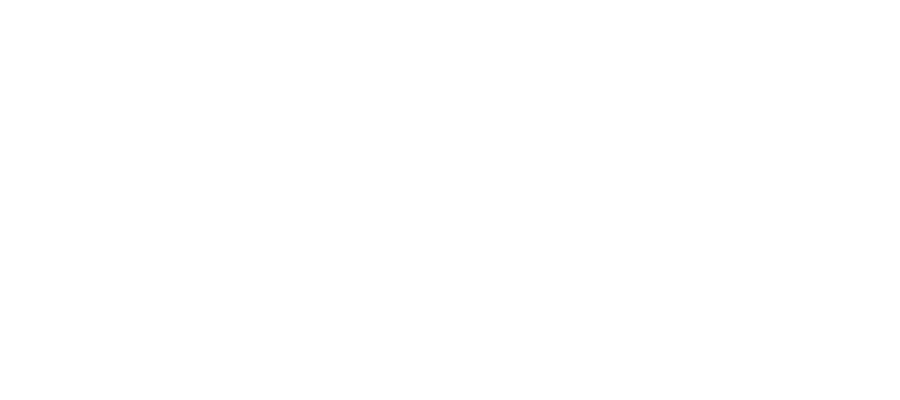

In [26]:
%matplotlib notebook
accuracyFig = plt.figure(figsize=(9,4))
accuracyFig.clf()

Epoch 1/3
8/8 [==============================] - 3s - loss: 0.7109 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 3s - loss: 0.6391 - acc: 0.5000
Epoch 3/3
8/8 [==============================] - 3s - loss: 0.5323 - acc: 0.5000
history :  {'loss': [0.71092331409454346, 0.63912725448608398, 0.53234505653381348], 'lr': [0.00019999999, 0.00019999999, 0.00019999999], 'acc': [0.5, 0.5, 0.5]}
g_loss :  0.435041


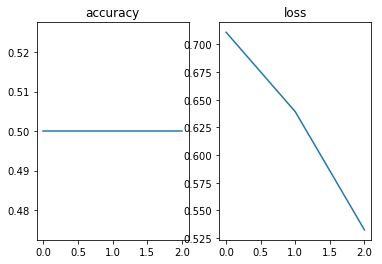

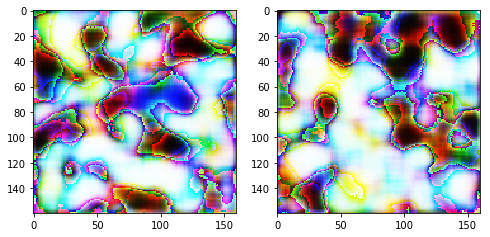

Epoch 1/3
8/8 [==============================] - 3s - loss: 1.5621 - acc: 0.5000
Epoch 2/3
8/8 [==============================] - 3s - loss: 0.6668 - acc: 0.6250
Epoch 3/3
8/8 [==============================] - 3s - loss: 0.8013 - acc: 0.5000
history :  {'loss': [1.562052845954895, 0.66678470373153687, 0.80129331350326538], 'lr': [0.00019999999, 0.00019999999, 0.00019999999], 'acc': [0.5, 0.625, 0.5]}
g_loss :  1.14895
Epoch 1/3
8/8 [==============================] - 3s - loss: 0.6068 - acc: 0.6250
Epoch 2/3
8/8 [==============================] - 3s - loss: 0.5311 - acc: 0.7500
Epoch 3/3
8/8 [==============================] - 4s - loss: 0.5611 - acc: 0.7500
history :  {'loss': [0.606758713722229, 0.53107911348342896, 0.56111049652099609], 'lr': [0.00019999999, 0.00019999999, 0.00019999999], 'acc': [0.625, 0.75, 0.75]}
g_loss :  1.76982
Epoch 1/3
8/8 [==============================] - 2s - loss: 0.6380 - acc: 0.6250
Epoch 2/3
8/8 [==============================] - 3s - loss: 0.3170 - ac

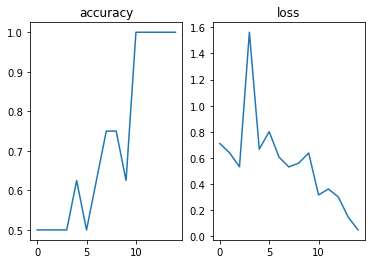

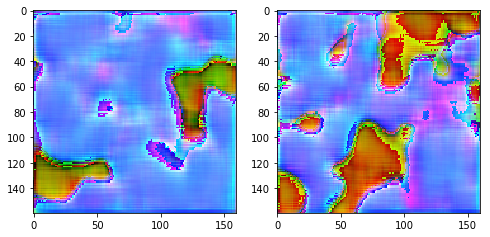

Epoch 1/3
8/8 [==============================] - 5s - loss: 0.0374 - acc: 1.0000
Epoch 2/3
8/8 [==============================] - 3s - loss: 0.0226 - acc: 1.0000
Epoch 3/3
8/8 [==============================] - 3s - loss: 0.0091 - acc: 1.0000
history :  {'loss': [0.037399627268314362, 0.022628610953688622, 0.0091035664081573486], 'lr': [0.00019999999, 0.00019999999, 0.00019999999], 'acc': [1.0, 1.0, 1.0]}
g_loss :  5.37371
Epoch 1/3
8/8 [==============================] - 2s - loss: 0.0108 - acc: 1.0000
Epoch 2/3
8/8 [==============================] - 3s - loss: 0.0127 - acc: 1.0000
Epoch 3/3
8/8 [==============================] - 3s - loss: 0.0031 - acc: 1.0000
history :  {'loss': [0.010780388489365578, 0.012744525447487831, 0.003113101702183485], 'lr': [0.00019999999, 0.00019999999, 0.00019999999], 'acc': [1.0, 1.0, 1.0]}
g_loss :  9.40778
Epoch 1/3
8/8 [==============================] - 4s - loss: 0.4933 - acc: 0.8750
Epoch 2/3
8/8 [==============================] - 3s - loss: 0.2560

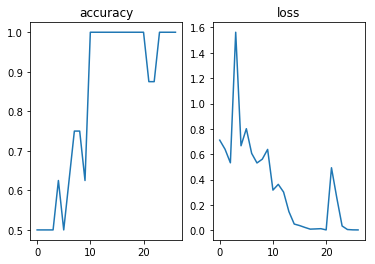

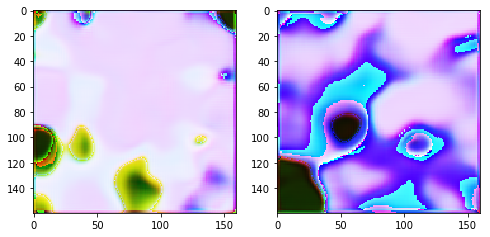

Epoch 1/3
8/8 [==============================] - 3s - loss: 1.2186 - acc: 0.7500
Epoch 2/3
8/8 [==============================] - 3s - loss: 0.2136 - acc: 0.8750
Epoch 3/3
8/8 [==============================] - 3s - loss: 0.3941 - acc: 0.6250
history :  {'loss': [1.2185553312301636, 0.21357375383377075, 0.39407286047935486], 'lr': [0.00019999999, 0.00019999999, 0.00019999999], 'acc': [0.75, 0.875, 0.625]}
g_loss :  13.1192
Epoch 1/3
8/8 [==============================] - 3s - loss: 0.4027 - acc: 0.8750
Epoch 2/3
8/8 [==============================] - 3s - loss: 0.3975 - acc: 0.7500
Epoch 3/3
8/8 [==============================] - 3s - loss: 0.4349 - acc: 0.8750
history :  {'loss': [0.4027121365070343, 0.3975239098072052, 0.43493366241455078], 'lr': [0.00019999999, 0.00019999999, 0.00019999999], 'acc': [0.875, 0.75, 0.875]}
g_loss :  9.74407
Epoch 1/3
8/8 [==============================] - 3s - loss: 0.1416 - acc: 1.0000
Epoch 2/3
8/8 [==============================] - 3s - loss: 0.1171

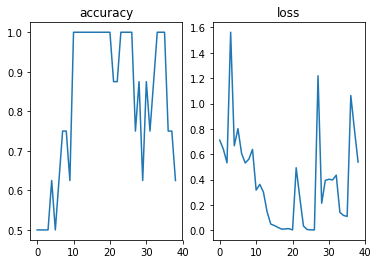

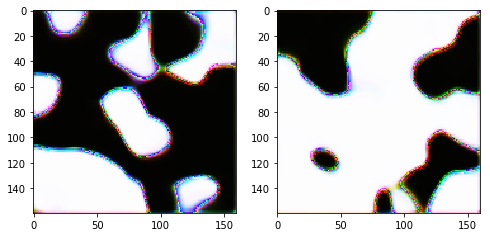

Epoch 1/3
8/8 [==============================] - 16s - loss: 0.4078 - acc: 0.6250
Epoch 2/3


In [ ]:
# %matplotlib notebook
%matplotlib inline

epochs = 20000
batch_size = 8
save_interval= 4
half_batch = int(batch_size / 2)

z = Input(shape=(100,))
acc = []
loss = []

img = generator(z)
discriminator.trainable = False
valid = discriminator(img)
combined = Model(z, valid)
# combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
combined.compile(loss='binary_crossentropy', optimizer='nadam')

for epoch in range(epochs):
    d_input, d_output = getData(half_batch)
    discriminator.trainable = True
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.6,
              patience=10, min_lr=0.001)
    #myPlot
    h = discriminator.fit(d_input, d_output, epochs = 3, verbose=1, callbacks=[reduce_lr])
    acc.extend(h.history.get('acc'))
    loss.extend(h.history.get('loss'))
    print('history : ', h.history)

    
    # ---------------------
    #  Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, 100))

    # The generator wants the discriminator to label the generated samples
    # as valid (ones)
    valid_y = np.array([1] * batch_size)

    # Train the generator
    g_loss = combined.train_on_batch(noise, valid_y)
    print('g_loss : ', g_loss)
    
    if epoch % save_interval == 0:
        plt.figure(accuracyFig.number)
        plt.subplot(1,2,1)
        plt.plot(acc, label="accuracy")
        plt.title('accuracy')
        plt.subplot(1,2,2)
        plt.title('loss')
        plt.plot(loss, label="loss")
        accuracyFig.canvas.draw()
#         plt.show()
        save_imgs(epoch)